### Importing Packages

In [4]:
import torch
from torch import nn,tensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torch.nn import functional as F
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import resnet50

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Downloading Dataset from animal-10 dataset from Kaggle
[Animal-10 Dataset](https://www.kaggle.com/alessiocorrado99/animals10)

In [3]:
os.mkdir('/root/.kaggle')

In [5]:
shutil.copy('kaggle.json','/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d alessiocorrado99/animals10

100% 586M/586M [00:07<00:00, 67.4MB/s]



In [8]:
! unzip -q animals10.zip

In [6]:
imgdir='./raw-img'

### Checking GPU 

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
def moveToDevice(x,y):
    return x.to(device),y.to(device)

### creating pytorch dataset

In [9]:
lng_to_eng = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider" , "scoiattolo": "squirrel"}
eng_to_lng = {"dog": "cane", "horse": "cavallo", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca","sheep":"pecora", "spider": "ragno", "squirrel": "scoiattolo"}

In [10]:
label_to_idx={i:n for n,i in enumerate(eng_to_lng)}
idx_to_label={v:k for k,v in label_to_idx.items()}

In [11]:
data={
    'label':[],
    'idx': [],
    'path': [],
    }
for c in os.listdir(imgdir):
    animal_dir=f'{imgdir}/{c}'
    for img in os.listdir(animal_dir):
        eng=lng_to_eng[c]
        if img.split('.')[-1] in ['jpg','jpeg','png']:
            data['label'].append(eng)
            data['idx'].append(label_to_idx[eng])
            data['path'].append(f'{animal_dir}/{img}')

In [12]:
df=pd.DataFrame(data)
df.head(n=10)

,label,idx,path
0,elephant,2,./raw-img/elefante/OIP-eJKtqRMInapH-MBNDEOSEQH...
1,elephant,2,./raw-img/elefante/OIP-t4ZQXGwFfaaQIW7xpdXd8QH...
2,elephant,2,./raw-img/elefante/OIP-yoZ1Q3dD3VlNtSnBurtbswH...
3,elephant,2,./raw-img/elefante/OIP-KkSCX7eO9H4rI9CdJ5oszwA...
4,elephant,2,./raw-img/elefante/OIP-ocZik9gD_TXCo5W1f9EiIAH...
5,elephant,2,./raw-img/elefante/ea36b00b2ff6043ed1584d05fb1...
6,elephant,2,./raw-img/elefante/eb3db20b20fd063ed1584d05fb1...
7,elephant,2,./raw-img/elefante/eb32b50d28f1093ed1584d05fb1...
8,elephant,2,./raw-img/elefante/OIP-X6S-X5KAyxVrp_6B0hrMuQH...
9,elephant,2,./raw-img/elefante/OIP-rdI7fBNlbP41ERjbwUYJPAH...


In [13]:
print(df.shape)

(26179, 3)


In [14]:
df_train,df_val= train_test_split(df, test_size=0.23, random_state=42)
df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)

In [15]:
print(df_train.shape,df_val.shape)

(20157, 3) (6022, 3)


In [16]:
class ImgDataSet(Dataset):
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        img= Image.open(self.df.loc[idx,'path']).convert('RGB')
        lbl= self.df.loc[idx,'idx']
        if self.transform is not None:
            img=self.transform(img)
        return img,lbl

In [17]:
transform={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size=(224,224)),
        transforms.ColorJitter(brightness=0.3,contrast=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(size=(224,244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
}

In [18]:
train_set=ImgDataSet(df_train,transform=transform['train'])
val_set=ImgDataSet(df_val,transform=transform['val'])

## Creating pytorch model
### Here trannsfer learning is applied using Resnet-50 pretrained weights

In [19]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier,self).__init__()
        rs=resnet50(pretrained=True)
        for i in rs.parameters():
            i.requires_grad=False
        rs.fc=nn.Sequential(nn.Dropout(p=0.5,inplace=False),nn.Linear(in_features=2048, out_features=10,bias=True))
        self.rs=rs
    
    def forward(self,x):
        return self.rs(x)

model= ImageClassifier()
model.to(device)

ImageClassifier(
  (rs): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [20]:
total=0
trainable=0
for i in model.parameters():
    if i.requires_grad==True:
        trainable+=i.numel()
    total+=i.numel()
print(f'total={total},trainable={trainable}')

total=23528522,trainable=20490


### Training Loop

In [24]:
mw='./weights'
os.mkdir(mw)

In [26]:
total_size=df.shape[0]
train_size=df_train.shape[0]
val_size=df_val.shape[0]

In [47]:
batch_size=32
epochs=5
optim=Adam(model.parameters(),lr=0.003)

In [26]:
def accuracy(preds,labels):
    return (torch.argmax(preds,dim=1)==labels).sum().item()

In [48]:
train_losses=[]
val_losses=[]
train_acc=[]
val_acc=[]
train_step= train_size//batch_size
val_step=val_size//batch_size
for epoch in range(epochs):
    print(f'epoch {epoch+1}/{epochs} started: ',end='  ')
    train_dl=DataLoader(train_set,batch_size,shuffle=True)
    val_dl=DataLoader(val_set,batch_size,shuffle=True)
    tloss=0
    tacc=0
    vloss=0
    vacc=0
    for i,(x,y) in enumerate(train_dl):
        x,y = moveToDevice(x,y)
        optim.zero_grad()
        y_pred=model(x)
        loss=F.cross_entropy(y_pred,y)
        loss.backward()
        optim.step()
        tloss+=loss.item()
        tacc+=accuracy(y_pred,y)
        if (i+10)%50==0:
            print('.',end='')
    tloss/=train_step
    tacc=tacc/train_size
    train_losses.append(tloss)
    train_acc.append(tacc)
    #validating
    print('\n validating please weight',end='  ')
    with torch.no_grad():
        for j,(x,y) in enumerate(val_dl):
            x,y = moveToDevice(x,y)
            y_pred=model(x)
            loss=F.cross_entropy(y_pred,y)
            vloss+=loss.item()
            vacc+=accuracy(y_pred,y)
            if (j+1)%20==0:
                print('.',end='')
        vloss/=val_step
        vacc=vacc/val_size
        val_losses.append(vloss)
        val_acc.append(vacc)   
    print('\nepoch {}/{} train_loss={},train_acc={},val_loss={},val_acc={}'.format(epoch+1,epochs,tloss,tacc,vloss,vacc))
    torch.save(model.state_dict(), 'weights/epoch_{}.pth'.format(epoch+1))

epoch 1/5 started:   ............
 validating please weight  .........
epoch 1/5 train_loss=0.5291842309749183,train_acc=0.8389145210100709,val_loss=0.23578002001654277,val_acc=0.9368980405181003
epoch 2/5 started:   ............
 validating please weight  .........
epoch 2/5 train_loss=0.530118098962217,train_acc=0.8579153643895421,val_loss=0.30896097327027705,val_acc=0.9201262039189638
epoch 3/5 started:   ............
 validating please weight  .........
epoch 3/5 train_loss=0.5861240016897645,train_acc=0.8543434042764301,val_loss=0.35723645816200433,val_acc=0.911989372301561
epoch 4/5 started:   ............
 validating please weight  .........
epoch 4/5 train_loss=0.599935242654504,train_acc=0.8629756412164509,val_loss=0.3123889296189287,val_acc=0.9256061109266025
epoch 5/5 started:   ............
 validating please weight  .........
epoch 5/5 train_loss=0.6419358708035491,train_acc=0.8572208165897703,val_loss=0.4282537503638602,val_acc=0.9081700431750249


### Plotting Results

In [49]:
def plotGraph(train_losses,val_losses,train_acc,val_acc):
    plt.figure(figsize=(8,8))
    plt.plot(train_losses,label='train_losses')
    plt.plot(val_losses,label='val_loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8,8))
    plt.plot(train_acc,label='train_acc')
    plt.plot(val_acc,label='val_acc')
    plt.legend()
    plt.show()

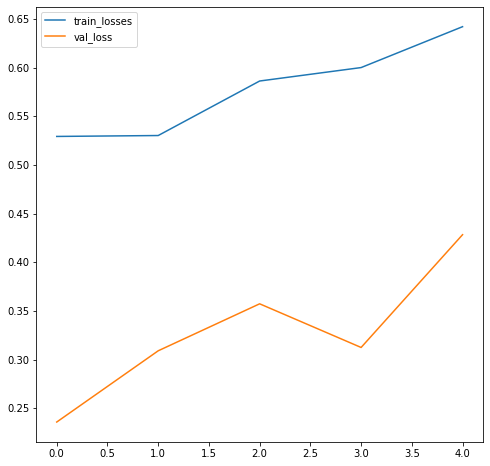

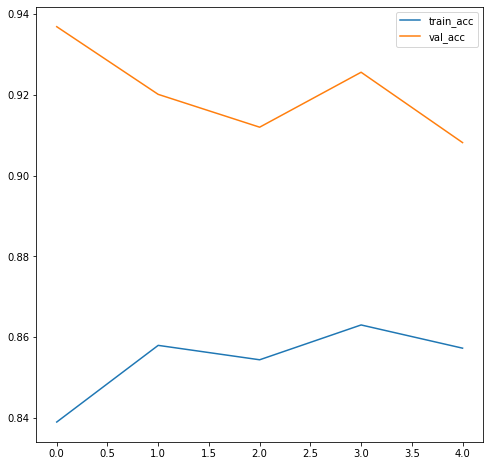

In [50]:
plotGraph(train_losses,val_losses,train_acc,val_acc)

### Evaluating model on complete Dataset

In [ ]:
model.load_state_dict(torch.load(f'weights/epoch_1.pth'))
model.eval()

In [39]:
def checkMetrics(model,df,batch_size):
    dl=DataLoader(ImgDataSet(df,transform=transform['val']),batch_size,shuffle=False)
    step=df.shape[0]//batch_size
    total_loss=0
    acc=0
    y_true=[]
    y_pred=[]
    print('Evaluating Results please wait ',end='')
    with torch.no_grad():
        for n,(x,y) in enumerate(dl):
            x,y = moveToDevice(x,y)
            y_=model(x)
            loss=F.cross_entropy(y_,y)
            total_loss+=loss.item()
            acc+=accuracy(y_,y)
            y_=torch.argmax(y_,dim=1).cpu().numpy()
            for i in range(len(x)):
                y_true.append(idx_to_label[y[i].cpu().item()])
                y_pred.append(idx_to_label[y_[i]])
            if (n+1)%100==0:
                print('.',end='')
        total_loss/=step
        acc/=df.shape[0]
    #Confusion Matrix
    print()
    col=np.unique(y_true)
    mat=metrics.confusion_matrix(y_true,y_pred)
    data={col[n]+'-Pred':mat.T[n] for n in range(len(col))}
    df=pd.DataFrame(data)
    df.index=[i+'-Real' for i in col]
    result={'pred':y_pred,'loss':total_loss,'acc':acc,'metrics':metrics.classification_report(y_true,y_pred),'confusion_matrix':df}
    return result

In [40]:
result=checkMetrics(model,df,32)

Evaluating Results please wait ........


In [41]:
print(f"Loss={result['loss']}, Accuracy={result['acc']}")
print(result['metrics'])

Loss=0.119095710436285, Accuracy=0.9648955269490813
              precision    recall  f1-score   support

   butterfly       0.98      0.96      0.97      2112
         cat       0.97      0.97      0.97      1668
     chicken       0.99      0.97      0.98      3098
         cow       0.90      0.91      0.91      1866
         dog       0.97      0.97      0.97      4863
    elephant       0.98      0.98      0.98      1446
       horse       0.96      0.94      0.95      2623
       sheep       0.92      0.95      0.93      1820
      spider       0.98      0.99      0.98      4821
    squirrel       0.96      0.98      0.97      1862

    accuracy                           0.96     26179
   macro avg       0.96      0.96      0.96     26179
weighted avg       0.97      0.96      0.96     26179



In [42]:
result['confusion_matrix']

,butterfly-Pred,cat-Pred,chicken-Pred,cow-Pred,dog-Pred,elephant-Pred,horse-Pred,sheep-Pred,spider-Pred,squirrel-Pred
butterfly-Real,2023,3,5,2,7,1,0,1,62,8
cat-Real,1,1612,0,0,30,1,1,4,2,17
chicken-Real,5,2,3005,7,23,4,5,8,25,14
cow-Real,2,2,2,1697,12,6,62,79,2,2
dog-Real,7,30,7,27,4713,5,31,22,5,16
elephant-Real,0,0,0,2,1,1424,4,10,3,2
horse-Real,1,3,0,80,36,8,2469,22,3,1
sheep-Real,0,0,0,60,14,5,9,1721,2,9
spider-Real,30,1,2,0,4,4,2,1,4771,6
squirrel-Real,2,5,3,3,10,1,1,7,5,1825
